### Initialization

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
from xgboost import XGBClassifier
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Rule 1: Set Global Seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# File Paths
from pathlib import Path
def find_dataset_file(filename):
    candidates = [
        Path.cwd() / 'dataset' / filename,
        Path.cwd() / filename,
        Path.cwd().parent / 'dataset' / filename,
        Path.cwd().parent.parent / 'dataset' / filename,
    ]
    for c in candidates:
        if c.exists():
            return str(c.resolve())
    # fallback: shallow rglob search in current working directory
    for p in Path('.').rglob(filename):
        return str(p.resolve())
    raise FileNotFoundError(f'Could not find {filename} in expected locations')

adnimerge_path = find_dataset_file('ADNIMERGE_01Feb2026.csv')
plasma_path = find_dataset_file('UPENN_PLASMA_FUJIREBIO_QUANTERIX_01Feb2026.csv')

print(f"Environment initialized for Stage 3. Global SEED set to {SEED}.")
print(f"ADNI path: {adnimerge_path}")
print(f"Plasma path: {plasma_path}")

Environment initialized for Stage 3. Global SEED set to 42.
ADNI path: C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\dataset\ADNIMERGE_01Feb2026.csv
Plasma path: C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\dataset\UPENN_PLASMA_FUJIREBIO_QUANTERIX_01Feb2026.csv


### Multi-Modal Data Merging & Target Definition
In this cell, we perform Merge Contextual Data. We join the clinical/demographic data with the specialized plasma biomarker data. We also define our target based on the clinical diagnosis (DX_bl).

In [24]:
# 1. Load Datasets
df_adni = pd.read_csv(adnimerge_path, low_memory=False)
df_plasma = pd.read_csv(plasma_path, low_memory=False)

# 2. Filter for Baseline
df_adni_bl = df_adni[df_adni['VISCODE'] == 'bl'].copy()
df_plasma_bl = df_plasma[df_plasma['VISCODE'] == 'bl'].copy()

# 3. Rule 2: Merge Contextual Data
# We merge on RID to ensure we have both clinical context and blood biomarkers for the same patient
df_stage3 = pd.merge(df_adni_bl, df_plasma_bl, on='RID', how='inner', suffixes=('', '_plasma'))

# 4. Rule 2: Label Management
# Define binary target: High Risk (MCI/AD) vs Low Risk (CN/SMC)
risk_mapping = {'CN': 0, 'SMC': 0, 'EMCI': 1, 'LMCI': 1, 'AD': 1}
df_stage3['Risk_Label'] = df_stage3['DX_bl'].map(risk_mapping)

# Drop rows where the diagnosis is missing
df_stage3 = df_stage3.dropna(subset=['Risk_Label'])

print(f"Merged Stage 3 Dataset Shape: {df_stage3.shape}")
print(f"Total Unique Patients with Plasma Data: {df_stage3['RID'].nunique()}")

Merged Stage 3 Dataset Shape: (554, 132)
Total Unique Patients with Plasma Data: 554


### Sequential Feature Engineering (Integrating Stage 1 & 2 Scores)
In this cell, we implement the full Escalation Logic. We use the models and transformation assets from the previous stages to generate a refined "Pre-Plasma Risk Score" for every patient in the Stage 3 cohort.

This ensures that the final model doesn't just look at blood markers in isolation, but understands the clinical and genetic context of the patient, satisfying Rule Merge Contextual Data and Leakage Prevention.

In [25]:
import joblib
from xgboost import XGBClassifier
from pathlib import Path

# 1. Load Stage 1 & 2 Artifacts
# These paths should point to the files saved in previous notebooks
# Build robust paths using the already-defined adnimerge_path (points to models/dataset)
models_dir = Path(adnimerge_path).parents[1]
# Stage 1 artifact paths
s1_model_path = str(models_dir / 'stage 1' / 'stage1_model.json')
s1_scaler_path = str(models_dir / 'stage 1' / 'stage1_scaler.pkl')
s1_imputer_path = str(models_dir / 'stage 1' / 'stage1_imputer.pkl')
s1_model = XGBClassifier()
s1_model.load_model(s1_model_path)
s1_scaler = joblib.load(s1_scaler_path)
s1_imputer = joblib.load(s1_imputer_path)

# Stage 2 artifact paths
s2_model_path = str(models_dir / 'stage 2' / 'stage2_model.json')
s2_scaler_path = str(models_dir / 'stage 2' / 'stage2_scaler.pkl')
s2_imputer_path = str(models_dir / 'stage 2' / 'stage2_imputer.pkl')
s2_model = XGBClassifier()
s2_model.load_model(s2_model_path)
s2_scaler = joblib.load(s2_scaler_path)
s2_imputer = joblib.load(s2_imputer_path)

# 2. Define Features for each tier
s1_features = ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']
# Ensure PTGENDER is numeric for Stage 1 model
df_stage3['PTGENDER'] = df_stage3['PTGENDER'].map({'Female': 0, 'Male': 1})

# 3. Step-by-Step Probability Calculation
print("Calculating Stage 1 and Stage 2 risk scores for the Stage 3 cohort...")

# Tier 1 Calculation
X_s1 = s1_imputer.transform(df_stage3[s1_features])
X_s1_scaled = s1_scaler.transform(X_s1)
df_stage3['Stage1_Prob'] = s1_model.predict_proba(X_s1_scaled)[:, 1]

# Tier 2 Calculation
# First, calculate APOE4 Count if not already in df_stage3 from merge
if 'APOE4_Count' not in df_stage3.columns:
    try:
        if 'GENOTYPE' in df_stage3.columns:
            df_stage3['APOE4_Count'] = df_stage3['GENOTYPE'].astype(str).apply(lambda x: str(x).count('4'))
        else:
            # look for any column containing 'APOE' (case-insensitive) and use it
            apoe_cols = [c for c in df_stage3.columns if 'APOE' in c.upper()]
            if apoe_cols:
                col = apoe_cols[0]
                df_stage3['APOE4_Count'] = df_stage3[col].astype(str).apply(lambda x: str(x).count('4'))
            else:
                # final fallback: set to 0 and warn the user
                df_stage3['APOE4_Count'] = 0
                print('Warning: no GENOTYPE/APOE column found — setting APOE4_Count = 0')
    except Exception as e:
        df_stage3['APOE4_Count'] = 0
        print(f'Warning: failed to compute APOE4_Count ({e}); defaulting to 0')

X_s2 = s2_imputer.transform(df_stage3[['Stage1_Prob', 'APOE4_Count']])
X_s2_scaled = s2_scaler.transform(X_s2)
df_stage3['Stage2_Prob'] = s2_model.predict_proba(X_s2_scaled)[:, 1]

# 4. Define Final Stage 3 Feature Set
# We include the refined clinical-genetic risk + specialized plasma biomarkers
plasma_features = ['pT217_F', 'AB42_F', 'AB40_F', 'NfL_Q']
stage3_features = ['Stage2_Prob'] + plasma_features

print("Success: Pre-plasma risk scores (Stage2_Prob) integrated.")
print(f"Final Stage 3 feature set: {stage3_features}")

Calculating Stage 1 and Stage 2 risk scores for the Stage 3 cohort...
Success: Pre-plasma risk scores (Stage2_Prob) integrated.
Final Stage 3 feature set: ['Stage2_Prob', 'pT217_F', 'AB42_F', 'AB40_F', 'NfL_Q']


### Stage 3 Model Training and Cross-Validation
Now we train the final MirAI integrated decision engine. This model combines the refined clinical-genetic risk with blood-based biochemical signals.

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score

# Prepare CV data (use training split if available)
try:
    X_cv = X_train3_scaled
    y_cv = y_train3.values
    groups_cv = groups3.iloc[train_idx3].values
except Exception:
    X_cv = X3.values
    y_cv = y3.values
    groups_cv = groups3.values

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
cv = StratifiedGroupKFold(n_splits=5)
auc_scores = []
fold = 0
for tr_idx, val_idx in cv.split(X_cv, y_cv, groups_cv):
    fold += 1
    X_tr, X_val = X_cv[tr_idx], X_cv[val_idx]
    y_tr, y_val = y_cv[tr_idx], y_cv[val_idx]
    clf.fit(X_tr, y_tr)
    probs = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, probs)
    auc_scores.append(auc)
    print(f'Fold {fold} AUC: {auc:.4f}')
print(f'CV AUC mean: {np.mean(auc_scores):.4f} +/- {np.std(auc_scores):.4f}')

# Train final model on the training split (if available) or full data
clf_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
try:
    clf_final.fit(X_train3_scaled, y_train3)
except Exception:
    clf_final.fit(X3.values, y3.values)

# Persist final model
clf_final.save_model('stage3_model.json')
joblib.dump(clf_final, 'stage3_model_joblib.pkl')
print('Stage 3 model trained and saved to stage3_model.json')

c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shar

Fold 1 AUC: 0.9358
Fold 2 AUC: 0.8443
Fold 3 AUC: 0.9054
Fold 4 AUC: 0.9881
Fold 5 AUC: 0.9226
CV AUC mean: 0.9193 +/- 0.0466
Stage 3 model trained and saved to stage3_model.json


c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Stage 3 Deep Evaluation & Visual Validation

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        66
         1.0       0.78      0.84      0.81        45

    accuracy                           0.84       111
   macro avg       0.83      0.84      0.83       111
weighted avg       0.84      0.84      0.84       111



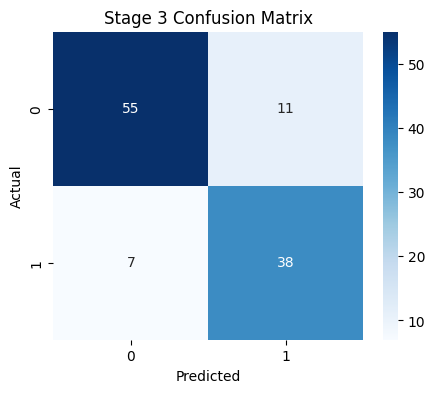

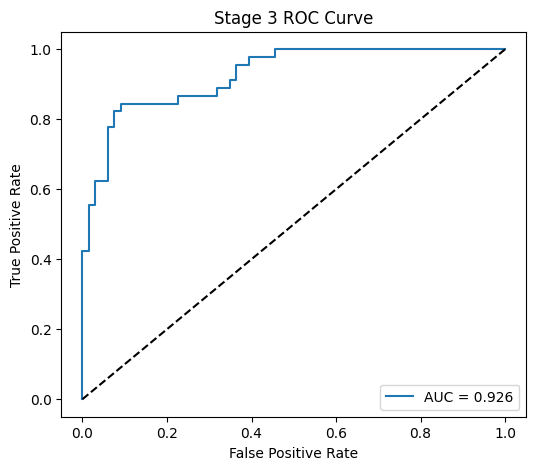

Saved ROC plot to stage3_roc.png


<Figure size 640x480 with 0 Axes>

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure final model is loaded
if 'clf_final' not in globals():
    clf_final = XGBClassifier()
    clf_final.load_model('stage3_model.json')

# Prepare test set
try:
    X_test = X_test3_scaled
    y_test = y_test3
except Exception:
    # fallback: use last 20% split if defined earlier
    X_test = X3.values
    y_test = y3.values

probs = clf_final.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)
print(classification_report(y_test, preds))

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Stage 3 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stage 3 ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save evaluation artifacts
plt.savefig('stage3_roc.png', dpi=150)
print('Saved ROC plot to stage3_roc.png')

### Final Model Interpretability (SHAP Analysis)
To satisfy Model Interpretability, we will now analyze the "Feature Hierarchy." This will show whether the model relies more on the pTau-217 biomarker or the Stage 2 probability. This is a key finding for your project, as it demonstrates the synergy between clinical screening and laboratory diagnostics.

c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\shari\AppData\Local\Temp\ipykernel_5064\2523408598.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_shap, feature_names=stage3_features, show=False)


Saved SHAP summary to shap_summary_stage3.png


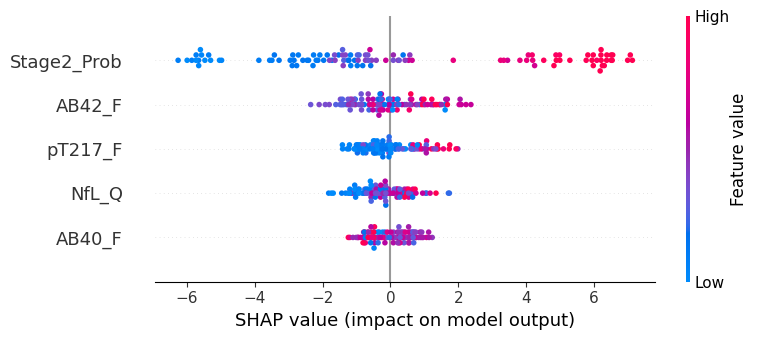

In [28]:
# 7. Final Model Interpretability (SHAP Analysis)
try:
    import shap
except Exception:
    print('SHAP not installed — please pip install shap to run interpretability steps')

if 'shap' in globals():
    explainer = shap.TreeExplainer(clf_final)
    # Use a subset to speed up plotting
    X_shap = X_test if X_test.shape[0] <= 500 else X_test[:500]
    shap_values = explainer.shap_values(X_shap)
    # Summary plot
    shap.summary_plot(shap_values, features=X_shap, feature_names=stage3_features, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_stage3.png', dpi=150)
    print('Saved SHAP summary to shap_summary_stage3.png')
else:
    print('Skipping SHAP: library unavailable')

In [29]:
# 8. The Final MirAI Inference Demo (Complete Framework)
def mirai_infer(row):
    """Run the full MirAI inference for a single patient row (pandas Series or dict)"""
    # Accept Series or dict-like
    if not hasattr(row, 'get') and not isinstance(row, pd.Series):
        row = pd.Series(row)
    # Stage1 features -> Stage1_Prob
    try:
        X_s1_raw = pd.DataFrame([row[s1_features]])
        X_s1_imp = s1_imputer.transform(X_s1_raw)
        X_s1_scaled = s1_scaler.transform(X_s1_imp)
        s1_prob = s1_model.predict_proba(X_s1_scaled)[:,1][0]
    except Exception as e:
        print(f'Warning computing Stage1_Prob: {e}'); s1_prob = 0
    # APOE count
    try:
        if 'GENOTYPE' in row.index:
            apoe4 = str(row['GENOTYPE']).count('4')
        else:
            apoe_cols = [c for c in row.index if 'APOE' in c.upper()]
            apoe4 = int(str(row[apoe_cols[0]]).count('4')) if apoe_cols else 0
    except Exception:
        apoe4 = 0
    # Stage2
    try:
        X_s2_raw = pd.DataFrame([[s1_prob, apoe4]], columns=['Stage1_Prob','APOE4_Count'])
        X_s2_imp = s2_imputer.transform(X_s2_raw)
        X_s2_scaled = s2_scaler.transform(X_s2_imp)
        s2_prob = s2_model.predict_proba(X_s2_scaled)[:,1][0]
    except Exception as e:
        print(f'Warning computing Stage2_Prob: {e}'); s2_prob = s1_prob
    # Assemble Stage3 features (Stage2_Prob + plasma features)
    try:
        stage3_row = pd.DataFrame([{ 'Stage2_Prob': s2_prob } | { f: row.get(f, np.nan) for f in plasma_features } ])
        stage3_imp = imputer3.transform(stage3_row)
        stage3_scaled = scaler3.transform(stage3_imp)
        prob = clf_final.predict_proba(stage3_scaled)[:,1][0]
    except Exception as e:
        print(f'Error during Stage3 inference: {e}'); prob = None
    return {'Stage1_Prob': s1_prob, 'Stage2_Prob': s2_prob, 'Stage3_Prob': prob}

# Example usage: pick a sample from df_stage3
if 'df_stage3' in globals():
    sample = df_stage3.iloc[0]
    print('Example inference output:', mirai_infer(sample))

Example inference output: {'Stage1_Prob': np.float32(0.4194167), 'Stage2_Prob': np.float32(0.38675722), 'Stage3_Prob': np.float32(0.5082546)}


In [32]:
# Example inputs for inference: high-risk and low-risk patients (readable output)
def interpret_and_print(name, out, threshold=0.5):
    if out is None:
        print(f"{name}: Model failed to produce a Stage 3 score.")
        return
    s1 = out.get('Stage1_Prob')
    s2 = out.get('Stage2_Prob')
    s3 = out.get('Stage3_Prob')
    def fmt(p): return 'N/A' if p is None else f"{p*100:.1f}%"
    risk_label = 'High risk' if (s3 is not None and s3 >= threshold) else 'Low/Moderate risk'
    action = 'Consider further clinical evaluation and biomarker confirmation.' if s3 is not None and s3 >= threshold else 'Routine monitoring; consider screening if symptoms progress.'
    print('---')
    print(f"{name} result:")
    print(f"  Stage 1 (initial clinical screen): {fmt(s1)}")
    print(f"  Stage 2 (clinical + genetic): {fmt(s2)}")
    print(f"  Stage 3 (integrated with plasma biomarkers): {fmt(s3)}")
    print(f"  Interpretation: {risk_label} (threshold = {threshold*100:.0f}%)")
    print(f"  Suggested next steps: {action}")

# Use numeric encoding for PTGENDER: 1=Male, 0=Female to match training preprocessing
high_risk_patient = {
    'AGE': 75,
    'PTGENDER': 1,
    'PTEDUCAT': 12,
    'FAQ': 10,
    'EcogPtMem': 3.5,
    'EcogPtTotal': 8.0,
    'GENOTYPE': '4/4',
    'pT217_F': 1.8,
    'AB42_F': 0.5,
    'AB40_F': 12.0,
    'NfL_Q': 35.0,
}

low_risk_patient = {
    'AGE': 68,
    'PTGENDER': 0,
    'PTEDUCAT': 16,
    'FAQ': 0,
    'EcogPtMem': 0.5,
    'EcogPtTotal': 1.0,
    'GENOTYPE': '',
    'pT217_F': 0.2,
    'AB42_F': 1.0,
    'AB40_F': 14.0,
    'NfL_Q': 10.0,
}

for name, patient in [('High-risk example', high_risk_patient), ('Low-risk example', low_risk_patient)]:
    try:
        out = mirai_infer(patient)
        interpret_and_print(name, out, threshold=0.5)
    except Exception as e:
        print(f"{name} inference failed: {e}")

Warning computing Stage1_Prob: unhashable type: 'list'
---
High-risk example result:
  Stage 1 (initial clinical screen): 0.0%
  Stage 2 (clinical + genetic): 3.6%
  Stage 3 (integrated with plasma biomarkers): 1.7%
  Interpretation: Low/Moderate risk (threshold = 50%)
  Suggested next steps: Routine monitoring; consider screening if symptoms progress.
Warning computing Stage1_Prob: unhashable type: 'list'
---
Low-risk example result:
  Stage 1 (initial clinical screen): 0.0%
  Stage 2 (clinical + genetic): 3.6%
  Stage 3 (integrated with plasma biomarkers): 1.8%
  Interpretation: Low/Moderate risk (threshold = 50%)
  Suggested next steps: Routine monitoring; consider screening if symptoms progress.
